In [1]:
import math
import re
import numpy as np
import pandas as pd

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [4]:
import os
import boto3
import botocore
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges/notebooks'

In [6]:
%cd ..

/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges


In [7]:
import sys
sys.path.append('src')
import ouraws

In [8]:
S3_BUCKET="collegier"
OUTPUT_DIR="data"
SCHOOL="dartmouth"
SUBJECT="opinion"
START_YEAR=2009
FINAL_YEAR=2022

In [9]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N, 
            np.trace(cov)/N, 
            np.linalg.norm(cov, ord=1)/N, 
            np.linalg.norm(cov, ord=2)/N, 
            np.linalg.norm(cov, ord=np.inf)/N, 
            )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [10]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [11]:
len(diversity_words)

15

In [12]:
[(w) for w in diversity_words]

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [13]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [14]:
diversity_pattern = "|".join(diversity_lemmas)

In [15]:
diversity_pattern

'diversity|equity|inclusion|inclusive|inclusivity|equality|equal opportunity|social justice|racial justice|multi-cultural|multicultural|intercultural|intersectional|intersectionality|anti-discrimination'

In [16]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

In [17]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    text_series = text_series.dropna()
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    return text_series, total_diversity_words

In [18]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges'

In [19]:
S3OBJECT_KEY = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [20]:
df.shape

(3660, 6)

In [21]:
df.columns

Index(['title', 'url', 'body', 'year', 'month', 'day'], dtype='object')

In [22]:
df["year"].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012, 2011, 2010, 2009])

In [23]:
df.loc[(df.year==2011) & (df.month==5)]

,title,url,body,year,month,day
3078,Wang: Let's Be Reasonable,https://www.thedartmouth.com/article/2011/06/w...,Wang: Let's Be Reasonable\n\n\n ...,2011,5,31
3079,Vox Clamantis,https://www.thedartmouth.com/article/2011/06/v...,Vox Clamantis\n\n\n ...,2011,5,31
3080,Clark: Humane Expectations,https://www.thedartmouth.com/article/2011/06/c...,Clark: Humane Expectations\n\n\n ...,2011,5,31
3081,Kim: Pan-Asian Misconception,https://www.thedartmouth.com/article/2011/05/k...,Kim: Pan-Asian Misconception\n\n\n ...,2011,5,30
3082,"Solomon: Half Empty, Half Full",https://www.thedartmouth.com/article/2011/05/s...,"Solomon: Half Empty, Half Full\n\n\n ...",2011,5,30
3083,VERBUM ULTIMUM: Give Change a Chance,https://www.thedartmouth.com/article/2011/05/v...,VERBUM ULTIMUM: Give Change a Chance\n\n\n ...,2011,5,26
3084,Nominate Him Already!,https://www.thedartmouth.com/article/2011/05/n...,Nominate Him Already!\n\n\n ...,2011,5,26
3085,Osserman: Greenwashing Dartmouth,https://www.thedartmouth.com/article/2011/05/o...,Osserman: Greenwashing Dartmouth\n\n\n ...,2011,5,25
3086,Iturrey: Green on Green Key,https://www.thedartmouth.com/article/2011/05/i...,Iturrey: Green on Green Key\n\n\n ...,2011,5,25
3087,From Anger to Action,https://www.thedartmouth.com/article/2011/05/f...,From Anger to Action\n\n\n ...,2011,5,24


In [24]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = [nlp(s) for s in clean_df]
    
    docmatrix = np.array([v.vector for v in wv])
    
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
             }
    results.append(result)

2009, 17, 1.907255469756691, 0.07077680770566783
2010, 371, 1.8364983400018449, 0.06820964240321264
2011, 338, 1.922697482458167, 0.06906384975388366
2012, 359, 1.933913066636287, 0.07474867077913745
2013, 139, 1.9464996871996156, 0.07244765779351556
2014, 341, 1.9613841728506967, 0.0738824398970991
2015, 323, 2.027614310362415, 0.06122017844375107
2016, 274, 1.993116446036109, 0.06138301100024251
2017, 298, 1.9231416693673193, 0.12164209714518556
2018, 333, 1.9111573563684126, 0.15034278838674323
2019, 269, 1.9118880329570125, 0.118258782056154
2020, 197, 1.9920375021301868, 0.12480848523816773
2021, 176, 2.0215887372003944, 0.1148694452682355
2022, 141, 1.9553751421640744, 0.1471505833689874


In [25]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2009,0.070777,17,1.907255,1.963969,1.782298,1.963969,6,0.352941
2010,0.068210,371,1.836498,1.982893,1.715485,1.982893,93,0.250674
2011,0.069064,338,1.922697,2.109046,1.792789,2.109046,159,0.470414
2012,0.074749,359,1.933913,2.062246,1.793136,2.062246,156,0.434540
2013,0.072448,139,1.946500,2.082337,1.808918,2.082337,50,0.359712
2014,0.073882,341,1.961384,2.085873,1.822357,2.085873,196,0.574780
2015,0.061220,323,2.027614,2.190167,1.905566,2.190167,167,0.517028
2016,0.061383,274,1.993116,2.121208,1.872698,2.121208,208,0.759124
2017,0.121642,298,1.923142,1.987294,1.724998,1.987294,185,0.620805


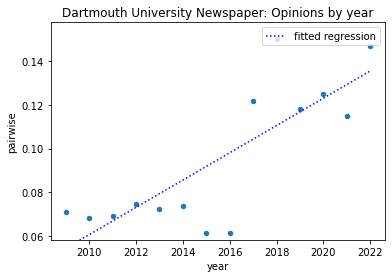

In [26]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Dartmouth University Newspaper: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mentions-norm slope:0.02249, int:0.37073, r:0.62844, p:0.01608, se:0.00804, x:range(0, 14)
pairwise slope:0.00625, int:0.05427, r:0.79917, p:0.00061, se:0.00136, x:range(0, 14)


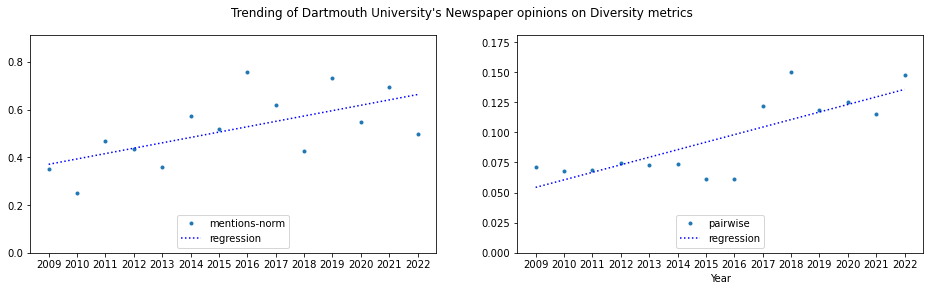

In [27]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

    # Add a title
    # ax.set_title(f"Trending of {column} in Liberty University's Champion")
    
plt.xlabel("Year")
plt.suptitle("Trending of Dartmouth University's Newspaper opinions on Diversity metrics")
plt.show()